In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
import re
import os
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy import array
from numpy import hstack
from statsmodels.graphics.gofplots import qqplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib
%matplotlib inline

## Keras Regression Metrics
- Mean Squared Error: MSE
- Mean Absolute Error: MAE
- Mean Absolute Percentage Error:MAPE
- Cosine Proximity: cosine_proximity, cosine

## data preprocessing

In [60]:
## change label: df_merge_model = label('cumulative_cases')
## process data
conn = sqlite3.connect('../data/hubs.db')
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
df_mob_sort = df_mob.sort_values(by=['HR_UID','DATE'])
df_health = pd.read_sql_query("SELECT * from Health_Indicators_ODHF", conn)
df_health1 = df_health[['HR_UID','Population_density', 'ambulatory','hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']]
mob_health = pd.merge(df_mob, df_health1, how='left', on=['HR_UID'])
df_COVID = pd.read_sql_query("SELECT * from Covid19", conn)
# total cols of 2 dataframe merged
pd_merge = pd.merge(mob_health, df_COVID, how='right', left_on=['DATE', 'HR_UID'], right_on=['report_date', 'HR_UID'])
max_date = df_COVID['report_date'].max()
pd_merge_new = pd_merge.loc[(pd_merge['DATE']>='2020-01-25') & (pd_merge['DATE']<=max_date)]
# dropping duplicte values on same HR_UID and Date
pd_merge_new.drop_duplicates(subset =["HR_UID", "DATE"], inplace = True) 
# minmax scaler
scaler = MinMaxScaler()
# minmax scaler
scaler1 = MinMaxScaler()
# add and remove cumulative_deaths, cumulative_cases
def label(label):
    lst = ['Md_PD', 'Mrr_PD',
        'Mgp_PD', 'Mp_PD', 'Mt_PD', 'Mw_PD', 'Mr_PD', 'M_PD', 'Md_MD',
        'Mrr_MD', 'Mgp_MD', 'Mp_MD', 'Mt_MD', 'Mw_MD', 'Mr_MD', 'M_MD','Md_RP', 'Mrr_RP',
       'Mgp_RP', 'Mp_RP', 'Mt_RP', 'Mw_RP', 'Mr_RP', 'M_RP', 'Md_MP', 'Mrr_MP',
       'Mgp_MP', 'Mp_MP', 'Mt_MP', 'Mw_MP', 'Mr_MP', 'M_MP','cases', 'cumulative_cases', 'deaths',
       'cumulative_deaths', 'Population_density','ambulatory','hospitals','nursing_residential']
    lst.remove(label)
    data = pd_merge_new[lst]

    data1 = pd_merge_new[[label]]
    data_scale = scaler.fit_transform(data)
    data_scale1 = scaler1.fit_transform(data1)
    df_data_scale = pd.DataFrame(data=data_scale,columns=lst)
    df_data_scale1 = pd.DataFrame(data=data_scale1,columns=[label])
    col_lst = list(set(pd_merge_new.columns.tolist()) - set(df_data_scale.columns.tolist())- set(df_data_scale1.columns.tolist()))
    pd_feature = pd_merge_new[col_lst]
    pd_feature.reset_index(inplace=True)
    df_merge_model = pd.concat([pd_feature, df_data_scale, df_data_scale1], axis=1)
    return df_merge_model

df_merge_model = label('cumulative_deaths')
df_merge_model.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


index HR_UID PRUID_y health_region                    HR_NAME PRUID_x  \
0      0   3553      35          peel  Peel Regional Health Unit      35   
1      1   3553      35          peel  Peel Regional Health Unit      35   
2      2   3553      35          peel  Peel Regional Health Unit      35   
3      3   3553      35          peel  Peel Regional Health Unit      35   
4      4   3553      35          peel  Peel Regional Health Unit      35   

      PROV        DATE report_date  Perceived_health_good  ...     Mr_MP  \
0  Ontario  2020-01-25  2020-01-25                  0.577  ...  0.153085   
1  Ontario  2020-01-26  2020-01-26                  0.577  ...  0.152386   
2  Ontario  2020-01-27  2020-01-27                  0.577  ...  0.151687   
3  Ontario  2020-01-28  2020-01-28                  0.577  ...  0.150965   
4  Ontario  2020-01-29  2020-01-29                  0.577  ...  0.150267   

       M_MP  cases  cumulative_cases  deaths  Population_density  ambulatory  \
0  0.531365    0.0               0.0     0.0            0.255652         1.0   
1  0.500511    0.0               0.0     0.0            0.255652         1.0   
2  0.514897    0.0               0.0     0.0            0.255652         1.0   
3  0.522561    0.0               0.0     0.0            0.255652         1.0   
4  0.526814    0.0               0.0     0.0            0.255652         1.0   

   hospitals  nursing_residential  cumulative_deaths  
0   0.714286                  1.0                0.0  
1   0.714286                  1.0                0.0  
2   0.714286                  1.0                0.0  
3   0.714286                  1.0                0.0  
4   0.714286                  1.0                0.0  

[5 rows x 51 columns]

## Model Input for Multiple Input Series
-  first dimension is the number of samples
-  second dimension is the number of time steps per sample
-  the last dimension specifies the number of parallel time series or the number of variables

## Multivariate model
- label: Cum_deaths
    - lag features: 7 days
- label: Cum_cases
    - lag features: 14 days


In [53]:
## change the label df_label = df_hr[['cumulative_cases_x']]
## change time_lag features
# # shift the value upward
df_merge_model['report_date'] = pd.to_datetime(df_merge_model['report_date'])
# df1 = df.set_index('DATE')
df_new = df_merge_model[['HR_UID','report_date','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP', 'report_date']]

def shift_df(lst, lag_date):
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            val = -lag_date_run
            df_new[col_name] = df_new.groupby(['HR_UID'])[a].shift(val)
    return df_new

def time_lag(time):
    df_new1 = shift_df(['HR_UID','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP'],time)
    # remove null row
    df_new1.dropna(inplace=True)
    # drop duplicated columns
    df_new2 = df_new1.loc[:,~df_new1.columns.duplicated()]

    ## Merge df back with health indicator
    df_new3 = pd.merge(df_merge_model, df_new2, how='left', on=['HR_UID','report_date'])
    # remove null row
    df_new3.dropna(inplace=True)
    return df_new3

df_new3 = time_lag(5)

# select one hr
def df_filter(hr, case, lag_date, label):
    df_hr = df_new3.loc[df_new3['HR_UID']==str(hr)]
    # list for input lagged features
    lst = ['cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP']
    col_lst = []
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            col_lst.append(col_name)
            
    lst1 = ['Mt_RP_x', 'Mt_MP_x', 'Mw_MD_x', 'Mgp_RP_x', 'Population_density','ambulatory',
               'hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']
    col_lst+=lst1
    
    if case:
        col_lst.append('cases_x')
    df_feature = df_hr[col_lst]
    df_label = df_hr[[label]]
    return df_feature, df_label, df_hr

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
# run
# define model

def lstm(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=50, verbose=2, validation_data=(X_test, y_test))
    return history, model

## HR: City of Ottawa Health Unit

In [27]:
## change time_lag features
# shape of df_feature: 129
df_feature, df_label, df_hr = df_filter(3551, True,14, 'cumulative_deaths_x')
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.1, random_state=42, shuffle=False)
# X_train shape (131, 123)
Y_train = y_train.to_numpy().reshape(-1,)
# Y_train.shape (131,)
Y_test = y_test.to_numpy().reshape(-1,)

In [30]:
## change time_lag features
# shape of df_feature: 129
df_feature, df_label, df_hr = df_filter(3551, True,7, 'cumulative_deaths_x')
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.1, random_state=42, shuffle=False)
# X_train shape (131, 123)
Y_train = y_train.to_numpy().reshape(-1,)
# Y_train.shape (131,)
Y_test = y_test.to_numpy().reshape(-1,)

In [33]:
## change time_lag features
# shape of df_feature: 129
df_feature, df_label, df_hr = df_filter(3551, True,5, 'cumulative_deaths_x')
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.1, random_state=42, shuffle=False)
# X_train shape (131, 123)
Y_train = y_train.to_numpy().reshape(-1,)
# Y_train.shape (131,)
Y_test = y_test.to_numpy().reshape(-1,)

In [35]:
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape
# (108, 1,  11)

(127, 1, 51)

In [36]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_30, model_30 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 30)

Train on 127 samples, validate on 15 samples
Epoch 1/50
 - 2s - loss: 6.3546e-04 - mse: 6.3546e-04 - mae: 0.0191 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0344
Epoch 2/50
 - 0s - loss: 5.3165e-04 - mse: 5.3165e-04 - mae: 0.0201 - val_loss: 0.0036 - val_mse: 0.0036 - val_mae: 0.0597
Epoch 3/50
 - 0s - loss: 4.4082e-04 - mse: 4.4082e-04 - mae: 0.0162 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0352
Epoch 4/50
 - 0s - loss: 4.0177e-04 - mse: 4.0177e-04 - mae: 0.0180 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0354
Epoch 5/50
 - 0s - loss: 2.7608e-04 - mse: 2.7608e-04 - mae: 0.0133 - val_loss: 0.0020 - val_mse: 0.0020 - val_mae: 0.0448
Epoch 6/50
 - 0s - loss: 2.3041e-04 - mse: 2.3041e-04 - mae: 0.0125 - val_loss: 6.7510e-04 - val_mse: 6.7510e-04 - val_mae: 0.0257
Epoch 7/50
 - 0s - loss: 1.8983e-04 - mse: 1.8983e-04 - mae: 0.0117 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0367
Epoch 8/50
 - 0s - loss: 1.5756e-04 - mse: 1.5756e-04 - mae: 0.0088 - val_loss: 9.7548

## Label: scaled_cum_deaths
- with lagged features

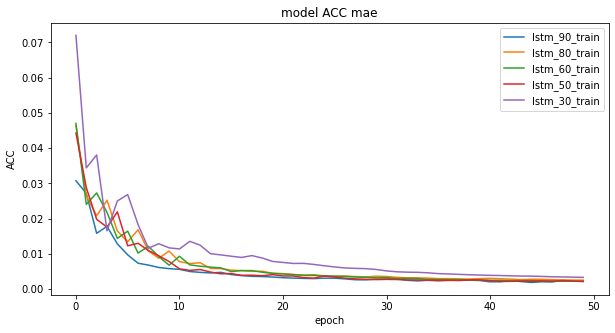

In [10]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90.history['mae'])
plt.plot(history_80.history['mae'])
plt.plot(history_60.history['mae'])
plt.plot(history_50.history['mae'])
plt.plot(history_30.history['mae'])
# plt.plot(history.history['val_mae'])
plt.title('model ACC mae')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_train', 'lstm_80_train', 'lstm_60_train', 'lstm_50_train', 'lstm_30_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

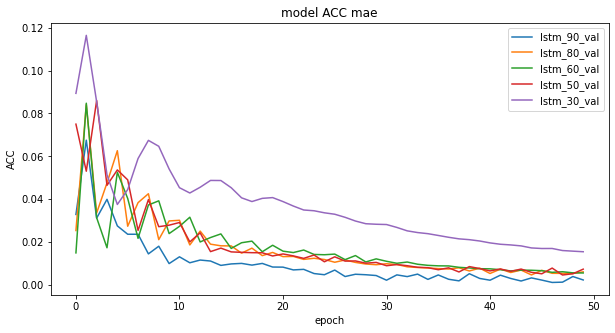

In [12]:
# with lagged 7 features
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90.history['val_mae'])
plt.plot(history_80.history['val_mae'])
plt.plot(history_60.history['val_mae'])
plt.plot(history_50.history['val_mae'])
plt.plot(history_30.history['val_mae'])
# plt.plot(history.history['val_mae'])
plt.title('model ACC mae')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_val','lstm_80_val', 'lstm_60_val', 'lstm_50_val', 'lstm_30_val'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_test_lag.png')
plt.show()

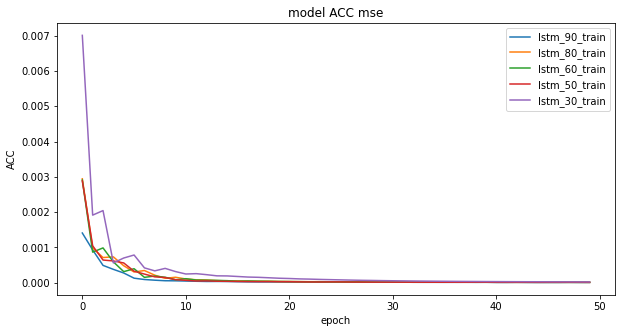

In [13]:
# with lagged7 features
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90.history['mse'])
plt.plot(history_80.history['mse'])
plt.plot(history_60.history['mse'])
plt.plot(history_50.history['mse'])
plt.plot(history_30.history['mse'])
# plt.plot(history.history['val_mae'])
plt.title('model ACC mse')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_train','lstm_80_train', 'lstm_60_train', 'lstm_50_train', 'lstm_30_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mse_train_lag.png')
plt.show()

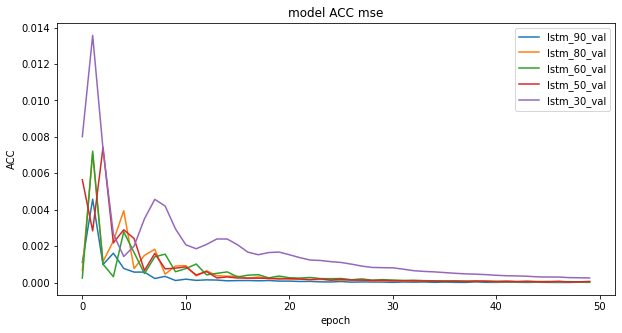

In [14]:
# with lagged 7 features
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90.history['val_mse'])
plt.plot(history_80.history['val_mse'])
plt.plot(history_60.history['val_mse'])
plt.plot(history_50.history['val_mse'])
plt.plot(history_30.history['val_mse'])
# plt.plot(history.history['val_mae'])
plt.title('model ACC mse')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_val','lstm_80_val', 'lstm_60_val', 'lstm_50_val', 'lstm_30_val'], loc='upper right')
# plt.savefig('photo/Multivariate/mse_test_lag.png')
plt.show()

## Comparison on LSTM complexity
- actual and predicted days plot
- lagged 7 days features

In [15]:
## TWO: plot another actual dates on train data plt.plot()
def inverse(scaler1, data):
    
    y_data = data.reshape(-1, 1)
    val_inv = scaler1.inverse_transform(y_data)
    return val_inv

def date_plot():
    then = df_hr['report_date'].max()-timedelta(len(x_test))

    end_date = datetime.strftime(then + timedelta(2), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(x_train)-2), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')

    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))

    # test dates
    then1 = df_hr['report_date'].max()

    end_date1 = datetime.strftime(then1 + timedelta(1), '%Y-%m-%d')
    date_end_date1 = datetime.strptime(end_date1, '%Y-%m-%d')

    fst_date1 = datetime.strftime(then1 - timedelta(len(x_test)-1), '%Y-%m-%d')
    date_fst_date1 = datetime.strptime(fst_date1, '%Y-%m-%d')


    days1 = mdates.drange(date_fst_date1,date_end_date1,dt.timedelta(days=1))
    
    # prediction
    prediction_90 = model_90.predict(x_test).flatten()
    prediction_80 = model_80.predict(x_test).flatten()
    test_inv = inverse(scaler1, Y_test)
    train_inv = inverse(scaler1, Y_train)
    inv_90 = inverse(scaler1, prediction_90)
    inv_80 = inverse(scaler1, prediction_80)

    plt.figure(figsize=(12, 5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.plot(days,prediction_90)
    plt.plot(days1,test_inv)
    plt.plot(days1,inv_90,'-o', color='gray')
#     plt.plot(days1,inv_80,'-o', color='red')
    plt.plot(days,train_inv)
    # plt.plot(days1,Y_test)
    # plt.plot(days,Y_train)
    plt.legend(['actual_test','pred_90','pred_80', 'actual_train'])

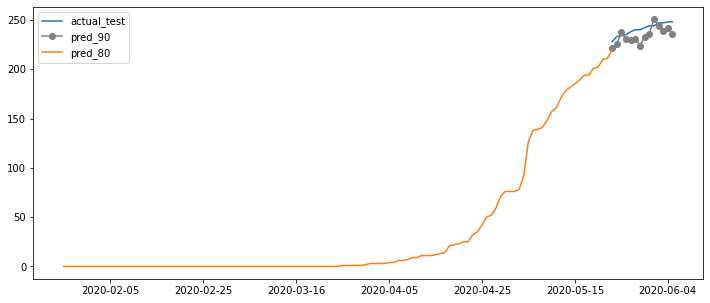

In [16]:
# time lagged features 14 days
date_plot()

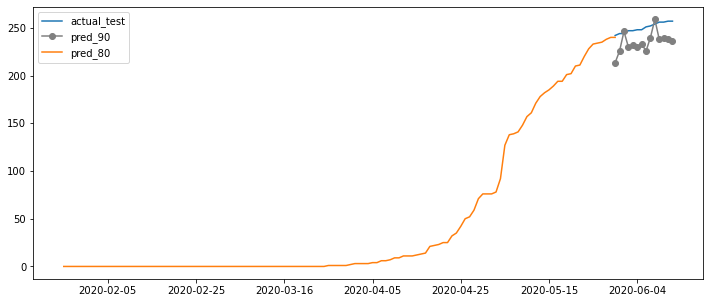

In [21]:
# time lagged features 7 days
date_plot()

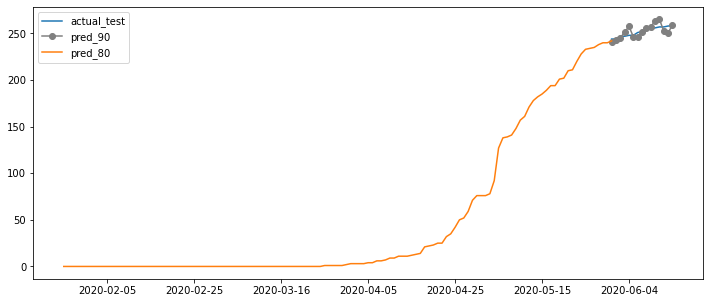

In [37]:
# time lagged features 5 days
date_plot()

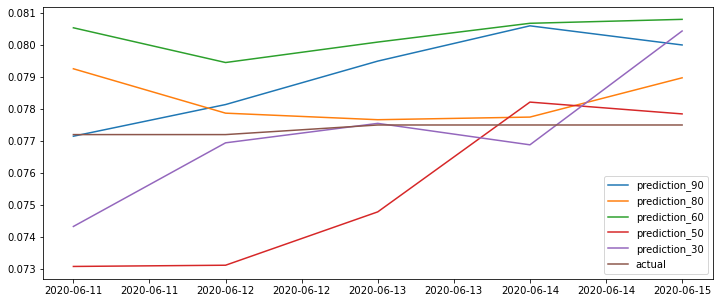

In [674]:
# normlaized value
# with lagged features
prediction_90 = model_90.predict(x_test).flatten()
prediction_80 = model_80.predict(x_test).flatten()
prediction_60 = model_60.predict(x_test).flatten()
prediction_50 = model_50.predict(x_test).flatten()
prediction_30 = model_30.predict(x_test).flatten()

then = df_hr['report_date'].max()

end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

fst_date = datetime.strftime(then - timedelta(len(x_test)-1), '%Y-%m-%d')
date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))

plt.figure(figsize=(12, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.plot(days,prediction_90)
plt.plot(days,prediction_80)
plt.plot(days,prediction_60)
plt.plot(days,prediction_50)
plt.plot(days,prediction_30)
plt.plot(days,Y_test)
plt.legend(['prediction_90','prediction_80', 'prediction_60', 'prediction_50', 'prediction_30', 'actual'])
# plt.savefig('photo/Multivariate/predict_norm.png')

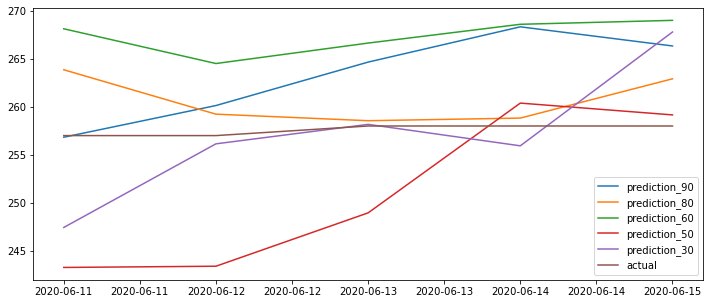

In [675]:
# inversed back
# with lagged features
prediction_90 = model_90.predict(x_test).flatten()
prediction_80 = model_80.predict(x_test).flatten()
prediction_60 = model_60.predict(x_test).flatten()
prediction_50 = model_50.predict(x_test).flatten()
prediction_30 = model_30.predict(x_test).flatten()

# now = dt.datetime(2020, 5, 11)
# then = dt.datetime(2020, 6, 7)

then = df_hr['report_date'].max()

end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

fst_date = datetime.strftime(then - timedelta(len(x_test)-1), '%Y-%m-%d')
date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


plt.figure(figsize=(12, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

y_test = Y_test.reshape(-1, 1)
prediction_90 = prediction_90.reshape(-1, 1)
prediction_80 = prediction_80.reshape(-1, 1)
prediction_60 = prediction_60.reshape(-1, 1)
prediction_50 = prediction_50.reshape(-1, 1)
prediction_30 = prediction_30.reshape(-1, 1)
test_inv = scaler1.inverse_transform(y_test)
inv_90 = scaler1.inverse_transform(prediction_90)
inv_80 = scaler1.inverse_transform(prediction_80)
inv_60 = scaler1.inverse_transform(prediction_60)
inv_50 = scaler1.inverse_transform(prediction_50)
inv_30 = scaler1.inverse_transform(prediction_30)


plt.plot(days,inv_90)
plt.plot(days,inv_80)
plt.plot(days,inv_60)
plt.plot(days,inv_50)
plt.plot(days,inv_30)
plt.plot(days,test_inv)
plt.legend(['prediction_90','prediction_80', 'prediction_60', 'prediction_50', 'prediction_30', 'actual'])

## Residual Analysis
- test set size 14 days

In [641]:
prediction = model_90.predict(x_test)
residuals = [Y_test[i]-prediction[i] for i in range(len(prediction))]
df_resid = pd.DataFrame(residuals)
df_resid.head()

0
0 -0.001432
1 -0.001084
2 -0.003526
3 -0.003866
4 -0.003066

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f967a45b0d0>]],
      dtype=object)

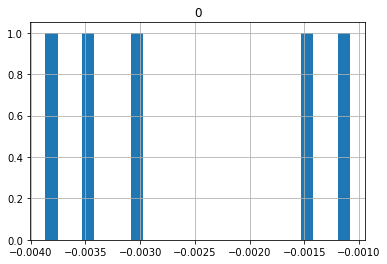

In [642]:
# histogram plot
# It's not quite gaussian, but we might expect that because the number of samples is very small
df_resid.hist(bins = 25)
# pyplot.show()

([<matplotlib.axis.YTick at 0x7f967a24c510>,
 [Text(0, 0, '0.0'),
  Text(0, 0, '0.5'),
  Text(0, 0, '1.0'),
  Text(0, 0, '1.5'),
  Text(0, 0, '2.0'),
  Text(0, 0, '2.5'),
  Text(0, 0, '3.0')])

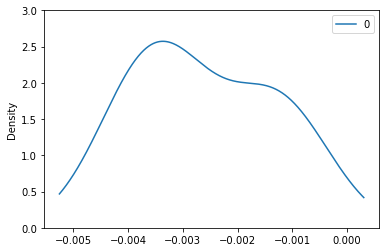

In [643]:
# density plot

fig=df_resid.plot(kind='kde')
plt.yticks(fig.get_yticks(), fig.get_yticks() / 100)

## Label: scaled_cum_cases

In [40]:
## change time_lag features
# shape of df_feature: 129
df_feature, df_label, df_hr = df_filter(3551, True,14, 'cumulative_cases_x')
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.1, random_state=42, shuffle=False)
# X_train shape (131, 123)
Y_train = y_train.to_numpy().reshape(-1,)
# Y_train.shape (131,)
Y_test = y_test.to_numpy().reshape(-1,)

In [49]:
## change time_lag features
# shape of df_feature: 129
df_feature, df_label, df_hr = df_filter(3551, True, 7, 'cumulative_cases_x')
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.1, random_state=42, shuffle=False)
# X_train shape (131, 123)
Y_train = y_train.to_numpy().reshape(-1,)
# Y_train.shape (131,)
Y_test = y_test.to_numpy().reshape(-1,)

In [54]:
## change time_lag features
# shape of df_feature: 129
df_feature, df_label, df_hr = df_filter(3551, True, 5, 'cumulative_cases_x')
X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.1, random_state=42, shuffle=False)
# X_train shape (131, 123)
Y_train = y_train.to_numpy().reshape(-1,)
# Y_train.shape (131,)
Y_test = y_test.to_numpy().reshape(-1,)

In [55]:
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape
# (108, 1,  11)

(127, 1, 51)

In [56]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_30, model_30 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 30)

Train on 127 samples, validate on 15 samples
Epoch 1/50
 - 2s - loss: 0.0016 - mse: 0.0016 - mae: 0.0308 - val_loss: 0.0077 - val_mse: 0.0077 - val_mae: 0.0877
Epoch 2/50
 - 0s - loss: 0.0012 - mse: 0.0012 - mae: 0.0263 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0364
Epoch 3/50
 - 0s - loss: 7.7796e-04 - mse: 7.7796e-04 - mae: 0.0255 - val_loss: 7.5982e-04 - val_mse: 7.5982e-04 - val_mae: 0.0274
Epoch 4/50
 - 0s - loss: 4.1030e-04 - mse: 4.1030e-04 - mae: 0.0175 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0523
Epoch 5/50
 - 0s - loss: 4.7948e-04 - mse: 4.7948e-04 - mae: 0.0186 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0371
Epoch 6/50
 - 0s - loss: 3.1220e-04 - mse: 3.1220e-04 - mae: 0.0138 - val_loss: 4.7107e-04 - val_mse: 4.7107e-04 - val_mae: 0.0214
Epoch 7/50
 - 0s - loss: 2.8482e-04 - mse: 2.8482e-04 - mae: 0.0130 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0316
Epoch 8/50
 - 0s - loss: 2.3049e-04 - mse: 2.3049e-04 - mae: 0.0132 - val_loss: 0.0010 - val_m

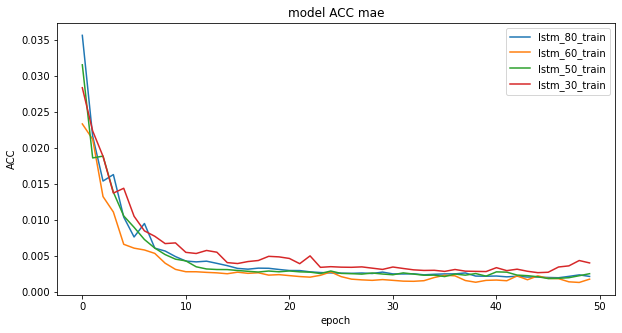

In [560]:
# with lagged 14 features
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_80.history['mae'])
plt.plot(history_60.history['mae'])
plt.plot(history_50.history['mae'])
plt.plot(history_30.history['mae'])
# plt.plot(history.history['val_mae'])
plt.title('model ACC mae')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_80_train', 'lstm_60_train', 'lstm_50_train', 'lstm_30_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag14_cum_case.png')
plt.show()

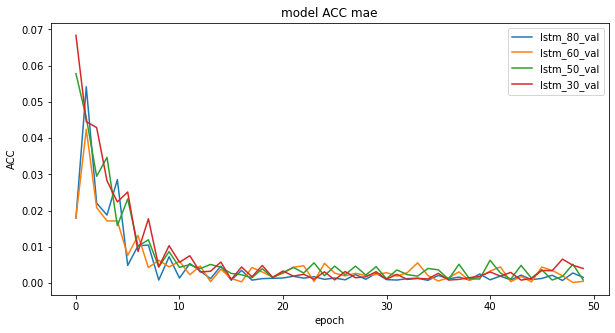

In [561]:
# with lagged 14 features
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_80.history['val_mae'])
plt.plot(history_60.history['val_mae'])
plt.plot(history_50.history['val_mae'])
plt.plot(history_30.history['val_mae'])
# plt.plot(history.history['val_mae'])
plt.title('model ACC mae')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_80_val', 'lstm_60_val', 'lstm_50_val', 'lstm_30_val'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_test_lag14_cum_case.png')
plt.show()

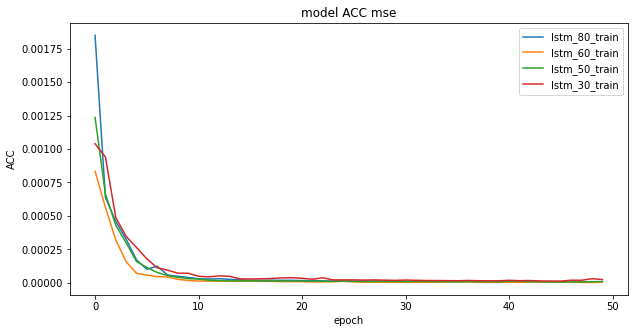

In [562]:
# with lagged 14 features
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_80.history['mse'])
plt.plot(history_60.history['mse'])
plt.plot(history_50.history['mse'])
plt.plot(history_30.history['mse'])
# plt.plot(history.history['val_mae'])
plt.title('model ACC mse')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_80_train', 'lstm_60_train', 'lstm_50_train', 'lstm_30_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mse_train_lag14_cum_case.png')
plt.show()

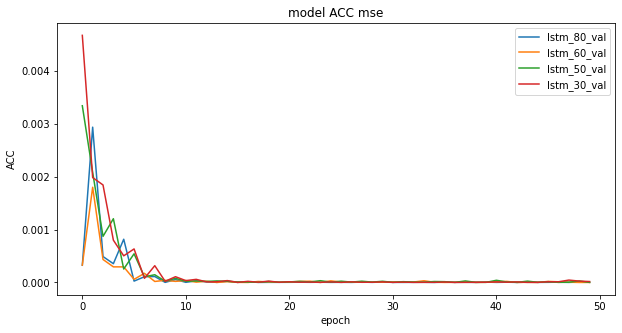

In [563]:
# with lagged 14 features
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_80.history['val_mse'])
plt.plot(history_60.history['val_mse'])
plt.plot(history_50.history['val_mse'])
plt.plot(history_30.history['val_mse'])
# plt.plot(history.history['val_mae'])
plt.title('model ACC mse')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_80_val', 'lstm_60_val', 'lstm_50_val', 'lstm_30_val'], loc='upper right')
# plt.savefig('photo/Multivariate/mse_test_lag14_cum_case.png')
plt.show()

## Comparison on LSTM complexity
- actual and predicted days plot
- lagged features 14 days

In [43]:
## TWO: plot another actual dates on train data plt.plot()
def inverse(scaler1, data):
    
    y_data = data.reshape(-1, 1)
    val_inv = scaler1.inverse_transform(y_data)
    return val_inv

def date_plot():
    then = df_hr['report_date'].max()-timedelta(len(x_test))

    end_date = datetime.strftime(then + timedelta(2), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(x_train)-2), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')

    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))

    # test dates
    then1 = df_hr['report_date'].max()

    end_date1 = datetime.strftime(then1 + timedelta(1), '%Y-%m-%d')
    date_end_date1 = datetime.strptime(end_date1, '%Y-%m-%d')

    fst_date1 = datetime.strftime(then1 - timedelta(len(x_test)-1), '%Y-%m-%d')
    date_fst_date1 = datetime.strptime(fst_date1, '%Y-%m-%d')


    days1 = mdates.drange(date_fst_date1,date_end_date1,dt.timedelta(days=1))
    
    # prediction
    prediction_90 = model_90.predict(x_test).flatten()
    prediction_80 = model_80.predict(x_test).flatten()
    prediction_60 = model_60.predict(x_test).flatten()
    # prediction
    prediction_50 = model_50.predict(x_test).flatten()
    prediction_30 = model_30.predict(x_test).flatten()
    test_inv = inverse(scaler1, Y_test)
    train_inv = inverse(scaler1, Y_train)
    inv_90 = inverse(scaler1, prediction_90)
    inv_80 = inverse(scaler1, prediction_80)
    inv_60 = inverse(scaler1, prediction_60)
    inv_50 = inverse(scaler1, prediction_50)
    inv_30 = inverse(scaler1, prediction_30)

    plt.figure(figsize=(12, 5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.plot(days,prediction_90)
    plt.plot(days1,test_inv)
    plt.plot(days,train_inv)
    plt.plot(days1,inv_90,'-o', color='red')
    plt.legend(['actual_test','actual_train','pred_90'])

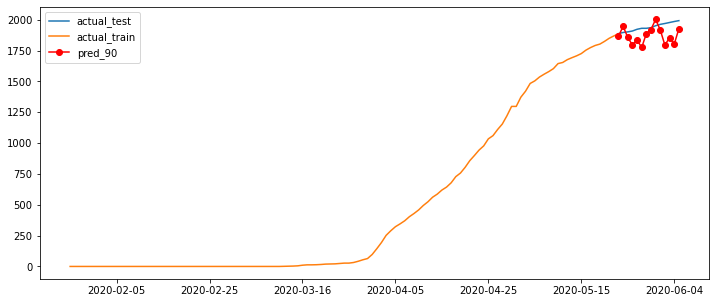

In [47]:
# time lag features 14 days
date_plot()

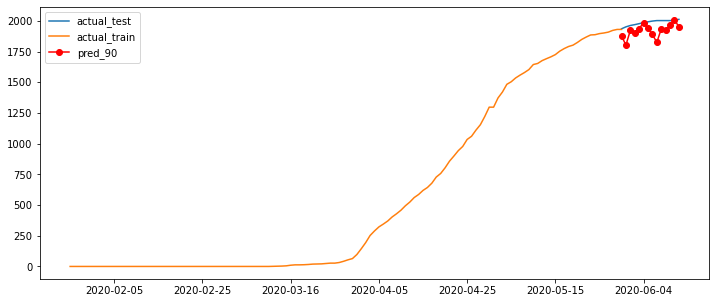

In [52]:
# time lag features 7 days
date_plot()

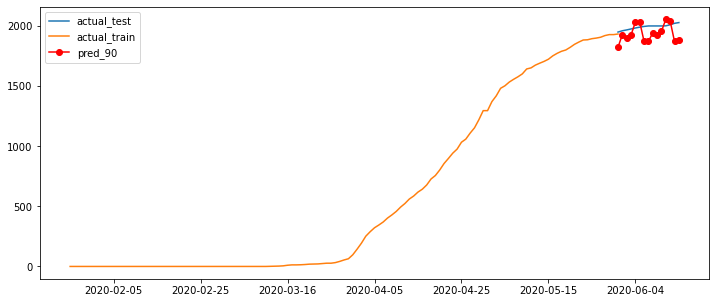

In [57]:
# time lag features 5 days
date_plot()

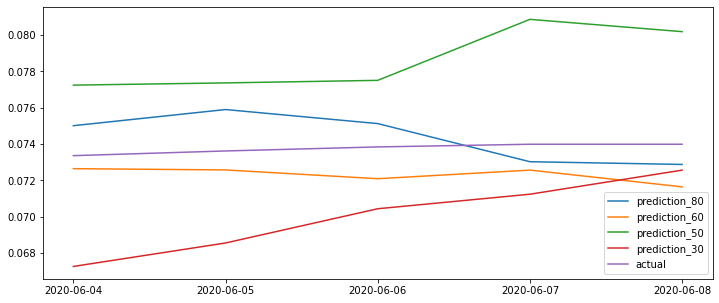

In [667]:
# with lagged 14features
prediction_80 = model_80.predict(x_test).flatten()
prediction_60 = model_60.predict(x_test).flatten()
prediction_50 = model_50.predict(x_test).flatten()
prediction_30 = model_30.predict(x_test).flatten()

then = df_hr['report_date'].max()

end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

fst_date = datetime.strftime(then - timedelta(len(x_test)-1), '%Y-%m-%d')
date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))
plt.figure(figsize=(12, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.plot(days,prediction_80)
plt.plot(days,prediction_60)
plt.plot(days,prediction_50)
plt.plot(days,prediction_30)
plt.plot(days,Y_test)
plt.legend(['prediction_80', 'prediction_60', 'prediction_50', 'prediction_30', 'actual'])
# plt.savefig('photo/Multivariate/predict_norm_lag14_cum_case.png')

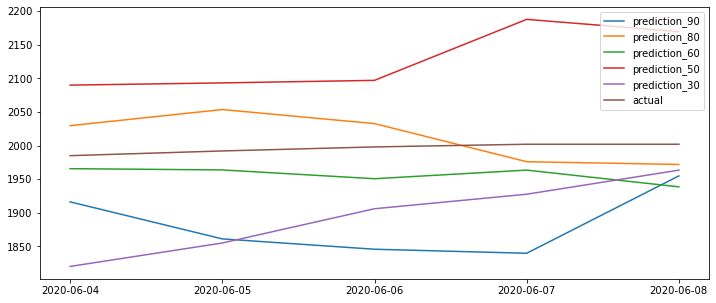

In [668]:
# with lagged features
prediction_90 = model_90.predict(x_test).flatten()
prediction_80 = model_80.predict(x_test).flatten()
prediction_60 = model_60.predict(x_test).flatten()
prediction_50 = model_50.predict(x_test).flatten()
prediction_30 = model_30.predict(x_test).flatten()

then = df_hr['report_date'].max()

end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

fst_date = datetime.strftime(then - timedelta(len(x_test)-1), '%Y-%m-%d')
date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))

plt.figure(figsize=(12, 5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

y_test = Y_test.reshape(-1, 1)
prediction_90 = prediction_90.reshape(-1, 1)
prediction_80 = prediction_80.reshape(-1, 1)
prediction_60 = prediction_60.reshape(-1, 1)
prediction_50 = prediction_50.reshape(-1, 1)
prediction_30 = prediction_30.reshape(-1, 1)
test_inv = scaler1.inverse_transform(y_test)
inv_90 = scaler1.inverse_transform(prediction_90)
inv_80 = scaler1.inverse_transform(prediction_80)
inv_60 = scaler1.inverse_transform(prediction_60)
inv_50 = scaler1.inverse_transform(prediction_50)
inv_30 = scaler1.inverse_transform(prediction_30)


plt.plot(days,inv_90)
plt.plot(days,inv_80)
plt.plot(days,inv_60)
plt.plot(days,inv_50)
plt.plot(days,inv_30)
plt.plot(days,test_inv)

plt.legend(['prediction_90','prediction_80', 'prediction_60', 'prediction_50', 'prediction_30', 'actual'])

## Residual Analysis

In [658]:
prediction = model_30.predict(x_test)
residuals = [Y_test[i]-prediction[i] for i in range(len(prediction))]
df_resid = pd.DataFrame(residuals)
df_resid.head()

0
0 -0.001621
1 -0.003640
2 -0.002680
3 -0.005193
4 -0.003054

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f96787356d0>]],
      dtype=object)

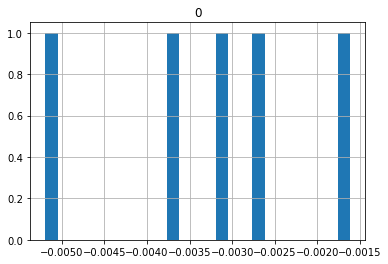

In [659]:
df_resid.hist(bins = 25)

([<matplotlib.axis.YTick at 0x7f9678455f10>,
 [Text(0, 0, '0.0'),
  Text(0, 0, '0.5'),
  Text(0, 0, '1.0'),
  Text(0, 0, '1.5'),
  Text(0, 0, '2.0'),
  Text(0, 0, '2.5'),
  Text(0, 0, '3.0')])

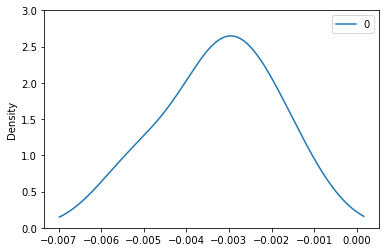

In [660]:
fig=df_resid.plot(kind='kde')
plt.yticks(fig.get_yticks(), fig.get_yticks() / 100)